## Image feature extraction

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from PIL import Image
# from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
# from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input


pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
image_data = pd.read_parquet('../Dataset/inception_men_image_features.parquet')
node_data = pd.read_parquet('../Dataset/final_filtered_meta_Clothing_Shoes_and_Jewelry_2018_men_clothing_only.parquet')

In [3]:
node_data.clothing_type.value_counts()

clothing_type
Shirts             36052
Active             18885
Jackets & Coats    14528
Underwear          10307
Jeans               5281
Pants               5133
Sleep & Lounge      4675
Socks               4167
Swim                3981
Shorts              3622
Name: count, dtype: int64

In [3]:
node_data.shape,image_data.shape

((106631, 21), (85336, 2048))

In [4]:
node_data = node_data.drop_duplicates('asin')

In [5]:
node_data = node_data[node_data.asin.isin(image_data.index)]

#### Cleaning price feature

In [6]:
from price_parser import Price
node_data['price'] = node_data.price.fillna('0').apply(lambda x: float(Price.fromstring(x).amount))

In [72]:
node_data['price'].min()

0.0

In [73]:
from sklearn.preprocessing import PowerTransformer
scaler = PowerTransformer()
node_data['price_power_transform'] = scaler.fit_transform(node_data[['price']])


#### Converting list 

In [8]:


for i in ['category', 'description', 'feature', 
        'also_view',
       'also_buy',
       'sub_cat', 'clothing_type']:
    try:
        
        node_data[i] = node_data[i].fillna('[]').apply(eval)
        print(i)
    except Exception as e:
        pass

category
description
feature
also_view
also_buy
sub_cat


In [9]:
node_data = node_data.set_index('asin')

#### Adding ratings from rating data to the product

In [10]:
rating_df = pd.read_parquet('../Dataset/ratings_cleaned.parquet')

In [11]:
node_data = pd.concat([node_data,rating_df],axis=1)

In [12]:
node_data = node_data[~node_data.sub_cat.isna()]

#### Extracting rank information from the rank feature which is mix of strings

In [13]:
node_data['rank_num'] = node_data['rank'].str.split('in').str[0]

In [14]:
node_data['rank_num'] = node_data['rank_num'].str.replace(r',|nan', '',regex=True)

In [15]:
node_data['rank_num'] = node_data['rank_num'].replace({'':''})

In [16]:
node_data['rank_num'] = node_data['rank_num'].str.extract('(\d+)',expand=False).fillna(-1).astype(int)

In [17]:
node_data['rank_num'] = node_data['rank_num'].replace({-1:node_data['rank_num'].max()})

In [18]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#### Converting rank using log transformation to focus more on higher rank( lower the better)

In [19]:
node_data['rank_num_log'] = np.log(node_data['rank_num'] + 1)

In [20]:
from sklearn.preprocessing import PowerTransformer
scaler = PowerTransformer(method = 'box-cox')

In [21]:
node_data['rank_num_power_transform'] = scaler.fit_transform(node_data[['rank_num']])


### NLP features

In [22]:
from unidecode import unidecode

def convert_accented_to_ascii(text):
    return unidecode(text)

In [23]:
node_data['title_cleaned'] =  node_data['title'].apply(convert_accented_to_ascii)

#### Extracting Important features using Rake

In [24]:
from rake_nltk import Rake

In [25]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kartik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kartik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [26]:
def get_rake_keywords(description):
    #instantiating Rake by default it uses English stopwords from NLTK and discards all punctuation chars
    r = Rake()
    
    #extract words by passing the text
    r.extract_keywords_from_text(description)
    
    #get the dictionary with key words and their scores
    keyword_dict_scores = r.get_word_degrees()
    
    #assign keywords to new columns
    return list(keyword_dict_scores.keys())

In [27]:
node_data['title_cleaned_keywords'] = node_data['title_cleaned'].apply(get_rake_keywords)

In [28]:
node_data['description_keywords'] = node_data['description'].str[0].fillna('').apply(get_rake_keywords)

#### Extracting TFIDF Vectors

In [29]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

In [30]:
vectorizer = TfidfVectorizer(stop_words='english')
X1 = vectorizer.fit_transform(node_data['title_cleaned_keywords'].str.join(' ').fillna(''))
X1

<85336x32980 sparse matrix of type '<class 'numpy.float64'>'
	with 1266619 stored elements in Compressed Sparse Row format>

In [31]:
# vectorizer = TfidfVectorizer(stop_words='english')
# X1 = vectorizer.fit_transform(node_data['description'].str[0].fillna(''))
# X1

In [32]:

def print_cluster(i):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

In [33]:
# # Optimal clusters is 

true_k = 10
X = X1
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,random_state=7)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(true_k):
    print_cluster(i)

Top terms per cluster:
Cluster 0:
 boxer
 brief
 underwear
 briefs
 pack
 men
 sexy
 rise
 low
 mens
Cluster 1:
 sleeve
 short
 long
 shirt
 men
 tee
 mens
 button
 polo
 plaid
Cluster 2:
 fit
 slim
 casual
 dress
 shirts
 men
 shirt
 mens
 sleeve
 long
Cluster 3:
 face
 north
 jacket
 men
 zip
 hoodie
 denali
 venture
 mens
 half
Cluster 4:
 socks
 crew
 pack
 men
 pair
 pairs
 cotton
 sock
 dress
 12
Cluster 5:
 jacket
 men
 leather
 mens
 coat
 hooded
 bomber
 fleece
 zip
 black
Cluster 6:
 men
 shirt
 mens
 pant
 shorts
 polo
 tee
 short
 nike
 big
Cluster 7:
 black
 lauren
 ralph
 polo
 shirt
 men
 large
 mens
 fit
 pony
Cluster 8:
 jean
 jeans
 fit
 straight
 men
 denim
 relaxed
 wrangler
 slim
 leg
Cluster 9:
 pants
 cotton
 men
 mens
 100
 pajama
 cargo
 casual
 shorts
 lounge


In [34]:
node_data['cluster_group'] = model.predict(X)
node_data['cluster_group'] = node_data['cluster_group'].apply(lambda x: f'cluster {x}')

#### Cleaning brand

#### Creating binary representation of brand

In [35]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
lb = LabelEncoder()

In [36]:
node_data['brand_label_encode'] = lb.fit_transform(node_data.brand.fillna(''))

In [37]:
node_data['brand_label_encode']

asin
1941489109    7537
3999852739     931
3999852070     931
3999862637     931
6342506256    2656
              ... 
B01HJ8Z0YQ    7439
B01HJ9R64M    2279
B01HJA98QA    1126
B01HJD2U08       0
B01HJFS7YO    5024
Name: brand_label_encode, Length: 85336, dtype: int32

In [38]:
label_encode_df = pd.DataFrame([list('{0:013b}'.format(i)) for i in node_data['brand_label_encode'].values],columns = [f'label_{i}' for i in range(1,14)],index = node_data.index)
label_encode_df = label_encode_df.astype(int)

In [39]:
node_data = pd.concat([node_data,label_encode_df],axis=1)

## target encoding based on categories, or based on also bought brand

In [40]:
cat_cols = ['cluster_group','clothing_type']

In [41]:
oh  = OneHotEncoder()
onehot_df = pd.DataFrame(oh.fit_transform(node_data[cat_cols]).toarray(),columns=oh.get_feature_names_out(),index=node_data.index)

In [42]:
node_data = pd.concat([node_data,onehot_df],axis=1)

In [43]:
node_data.columns

Index(['category', 'description', 'title', 'brand', 'feature', 'rank', 'date',
       'imageURL', 'imageURLHighRes', 'also_view', 'price', 'fit', 'also_buy',
       'main_cat', 'tech1', 'details', 'similar_item', 'tech2', 'sub_cat',
       'clothing_type', 'avg_rating', 'med_rating', 'no_of_ratings',
       'rank_num', 'rank_num_log', 'rank_num_power_transform', 'title_cleaned',
       'title_cleaned_keywords', 'description_keywords', 'cluster_group',
       'brand_label_encode', 'label_1', 'label_2', 'label_3', 'label_4',
       'label_5', 'label_6', 'label_7', 'label_8', 'label_9', 'label_10',
       'label_11', 'label_12', 'label_13', 'cluster_group_cluster 0',
       'cluster_group_cluster 1', 'cluster_group_cluster 2',
       'cluster_group_cluster 3', 'cluster_group_cluster 4',
       'cluster_group_cluster 5', 'cluster_group_cluster 6',
       'cluster_group_cluster 7', 'cluster_group_cluster 8',
       'cluster_group_cluster 9', 'clothing_type_Active',
       'clothing_type_Jac

In [77]:
cols_selected = [ 'price_power_transform', 'also_buy',
       'avg_rating',  'no_of_ratings',
       'rank_num_power_transform', 'label_1',
       'label_2', 'label_3', 'label_4', 'label_5', 'label_6', 'label_7',
       'label_8', 'label_9', 'label_10', 'label_11', 'label_12', 'label_13',
       'cluster_group_cluster 0', 'cluster_group_cluster 1',
       'cluster_group_cluster 2', 'cluster_group_cluster 3',
       'cluster_group_cluster 4', 'cluster_group_cluster 5',
       'cluster_group_cluster 6', 'cluster_group_cluster 7',
       'cluster_group_cluster 8', 'cluster_group_cluster 9',
       'clothing_type_Active', 'clothing_type_Jackets & Coats',
       'clothing_type_Jeans', 'clothing_type_Pants', 'clothing_type_Shirts',
       'clothing_type_Shorts', 'clothing_type_Sleep & Lounge',
       'clothing_type_Socks', 'clothing_type_Swim', 'clothing_type_Underwear'
       ]

In [78]:
node_data[cols_selected].dtypes

price_power_transform            float64
also_buy                          object
avg_rating                       float64
no_of_ratings                    float64
rank_num_power_transform         float64
label_1                            int32
label_2                            int32
label_3                            int32
label_4                            int32
label_5                            int32
label_6                            int32
label_7                            int32
label_8                            int32
label_9                            int32
label_10                           int32
label_11                           int32
label_12                           int32
label_13                           int32
cluster_group_cluster 0          float64
cluster_group_cluster 1          float64
cluster_group_cluster 2          float64
cluster_group_cluster 3          float64
cluster_group_cluster 4          float64
cluster_group_cluster 5          float64
cluster_group_cl

In [79]:
node_data.to_parquet('../Dataset/processed_men_clothing_data.parquet')

### Graph Creation

In [97]:
def generate_graph(df,id_col = 'asin',alos_bought = 'also_buy',include_img=False):
    ## check if tensorflow can do manual seed
    torch.manual_seed(0)
    df_full_explode = df.copy()
    df_full_explode = df_full_explode.explode('also_buy')
    final_list = df.asin
    # df_full_explode = df_full_explode[(df_full_explode.also_buy.isin(df_full.asin)) | (df_full_explode.also_buy.isna()) ]
    df_full_explode.also_buy = np.where(df_full_explode.also_buy.isin(final_list),df_full_explode.also_buy,np.nan)
    df_full_explode = df_full_explode.drop_duplicates(['asin','also_buy'])
    print("Exploded df shape", df_full_explode.shape)

    
    edges = df_full_explode[~df_full_explode.also_buy.isna()][['asin', 'also_buy']].drop_duplicates(['asin', 'also_buy'])
    all_nodes = list(edges.asin) + list(edges.also_buy)
    all_nodes = sorted(list(set(all_nodes)))
    # print(all_nodes)
    #Map String ASINs (IDs) to Int IDs
    asin_map_dict = pd.Series(all_nodes).reset_index(drop=True).to_dict()
    asin_map = {v: k for k, v in asin_map_dict.items()}
    print(len(asin_map))
    edges['asin'] = edges.asin.apply(lambda x: asin_map[x])
    edges['also_buy'] = edges.also_buy.apply(lambda x: asin_map[x])
    edges = edges.sort_values(['asin'])
    edges = edges.reset_index(drop=True)
    # all_nodes = list(edges.asin) + list(edges.also_buy)
    # all_nodes = list(set(all_nodes))
    print('edges',edges.shape)

    nodes = df[df.asin.isin(all_nodes)].copy()
    nodes['asin_mapped'] = nodes.asin.apply(lambda x: asin_map[x])
    nodes = nodes.set_index('asin_mapped').sort_index()
    # nodes = nodes.drop(columns = ['asin','also_buy'])
    # node_features = torch.Tensor(X)
    # # node_labels = torch.from_numpy(text_df['niche'].astype('category').cat.codes.to_numpy())
    # edges_src = torch.from_numpy(edges['asin'].to_numpy())
    # edges_dst = torch.from_numpy(edges['also_buy'].to_numpy())

    # #Build Graph
    # g = dgl.graph((edges_src, edges_dst))
    # g.ndata['feat'] = node_features
    # g.ndata['label'] = node_labels
    return nodes,edges

from sklearn.feature_extraction.text import TfidfVectorizer



### Train Test Split

In [98]:

from dgl.nn import SAGEConv
import dgl.function as fn
from umap.umap_ import UMAP
from sklearn.metrics import roc_auc_score
import dgl
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp
import json
import gzip
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
import dgl.data
import os
import random
import datetime
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from PIL import Image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import pickle


In [101]:
node,edges = generate_graph(node_data[cols_selected].reset_index())

Exploded df shape (105780, 39)
10867
edges (20554, 2)


In [102]:
node.to_parquet('../Dataset/nodes_without_image.parquet')
edges.to_parquet('../Dataset/edges_without_image.parquet')

In [2]:
import pandas as pd

In [3]:
image_data = pd.read_parquet('../Dataset/inception_men_image_features.parquet')

In [10]:
from sklearn.cluster import  KMeans
import matplotlib.pyplot as plt

In [9]:
X = image_data
from sklearn.cluster import KMeans
cs = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X)
    print(i)
    cs.append(kmeans.inertia_)


1
2
3
4
5
6
7
8
9
10


NameError: name 'plt' is not defined

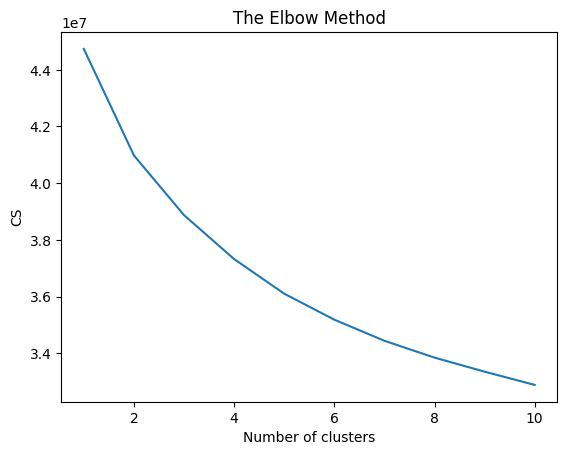

In [11]:
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

In [7]:
# # Optimal clusters is 

def print_cluster(i):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    
true_k = 10

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,random_state=7)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(true_k):
    print_cluster(i)

Top terms per cluster:


NameError: name 'vectorizer' is not defined

In [93]:
pd.merge(node,image_data.reset_index().rename(columns={'index':'asin'}),on='asin')

,asin,price_power_transform,also_buy,avg_rating,no_of_ratings,rank_num_power_transform,label_1,label_2,label_3,label_4,...,vec_2038,vec_2039,vec_2040,vec_2041,vec_2042,vec_2043,vec_2044,vec_2045,vec_2046,vec_2047
0,1941489109,0.776,[],5.000,1.000,1.909,1,1,1,0,...,1.122,1.092,0.427,0.094,0.455,0.396,1.035,0.974,0.862,0.143
1,3999852070,1.630,[],4.500,8.000,0.182,0,0,0,1,...,0.433,0.924,0.011,0.010,0.238,0.000,0.097,0.339,1.629,1.152
2,3999852739,1.655,[],4.667,3.000,0.040,0,0,0,1,...,0.129,0.000,0.054,0.148,0.139,0.038,0.000,0.604,1.171,1.522
3,3999862637,1.566,[],4.500,4.000,-0.090,0,0,0,1,...,0.518,0.000,0.029,0.614,0.166,0.011,0.406,0.613,0.300,1.257
4,6342502943,1.268,[],4.000,6.000,-0.511,0,0,1,0,...,0.586,0.089,0.011,0.000,0.506,1.639,0.009,0.039,0.015,0.372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85331,B01HJ8Z0YQ,1.263,[],5.000,2.000,0.554,1,1,1,0,...,0.567,0.029,0.288,3.020,1.730,0.000,0.201,0.146,0.928,0.227
85332,B01HJ9R64M,-0.447,"[B01DNAZSY6, B014KBHIT0, B01N2H9DB9, B01COHR2X...",3.250,4.000,-0.178,0,1,0,0,...,0.401,0.250,0.214,1.016,0.422,0.015,0.070,0.045,0.816,0.012
85333,B01HJA98QA,1.125,[B07C4MD591],1.500,8.000,-0.280,0,0,1,0,...,0.464,0.391,1.116,0.346,1.773,0.823,0.001,1.697,0.226,0.225
85334,B01HJD2U08,1.369,[B077Y4ZLL2],5.000,2.000,-0.512,0,0,0,0,...,0.294,0.008,0.874,0.092,0.050,0.789,0.647,1.039,0.083,1.417


In [90]:
pd.merge(image_data.reset_index())

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,vec_2038,vec_2039,vec_2040,vec_2041,vec_2042,vec_2043,vec_2044,vec_2045,vec_2046,vec_2047
index,,,,,,,,,,,,,,,,,,,,,
1941489109,0.000,0.314,0.048,0.180,0.318,0.056,0.103,1.528,0.765,1.344,...,1.122,1.092,0.427,0.094,0.455,0.396,1.035,0.974,0.862,0.143
3999852739,0.024,0.390,0.177,0.027,0.007,0.063,0.693,0.195,0.348,0.044,...,0.129,0.000,0.054,0.148,0.139,0.038,0.000,0.604,1.171,1.522
3999852070,0.001,0.081,0.251,0.377,0.102,0.342,1.704,0.039,0.347,0.000,...,0.433,0.924,0.011,0.010,0.238,0.000,0.097,0.339,1.629,1.152
3999862637,0.034,0.000,0.072,0.094,0.001,0.159,0.671,0.000,0.324,0.000,...,0.518,0.000,0.029,0.614,0.166,0.011,0.406,0.613,0.300,1.257
6342506256,0.424,0.344,0.015,0.532,1.518,0.512,0.469,0.476,0.388,0.160,...,0.387,0.024,0.325,0.878,0.604,0.129,0.073,0.896,0.321,0.155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B01HJ8Z0YQ,0.939,0.084,0.557,0.373,0.118,0.000,0.209,0.264,0.605,0.597,...,0.567,0.029,0.288,3.020,1.730,0.000,0.201,0.146,0.928,0.227
B01HJ9R64M,0.364,0.535,0.249,1.116,0.821,0.155,0.343,0.418,1.081,0.200,...,0.401,0.250,0.214,1.016,0.422,0.015,0.070,0.045,0.816,0.012
B01HJA98QA,0.406,0.425,0.224,0.146,0.110,0.732,0.260,0.153,0.291,0.700,...,0.464,0.391,1.116,0.346,1.773,0.823,0.001,1.697,0.226,0.225


### Extracting Rating Information

In [89]:
df = pd.read_csv("../Dataset/Clothing_Shoes_and_Jewelry.csv",header=None) 
df.shape

(32292099, 4)

In [90]:
df.columns = ['asin','user_id','rating','timestamp']

In [96]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

In [99]:
df = df.sort_values( ['asin','user_id','timestamp']).drop_duplicates(['asin','user_id'],keep='last')

In [100]:
df.shape

(31663536, 4)

In [103]:
rating_df = df.groupby('asin').agg({
    'rating':['mean','median'],
    'user_id':'count'
})

In [106]:
rating_df.columns = ['avg_rating','med_rating','no_of_ratings']

In [108]:
rating_df.to_parquet('../Dataset/ratings_cleaned.parquet')

In [ ]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp
import json
import gzip
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
import dgl.data
torch.manual_seed(0)
import random
random.seed(0)
np.random.seed(0)

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# base_model_2 = InceptionV3(weights='imagenet', include_top=True, input_shape=(299, 299, 3))
# base_model_2.summary()

In [5]:
# Load pre-trained ResNet50 model without top (classification) layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(None, None, 3))

# Define Faster R-CNN architecture on top of ResNet50 backbone
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Global Average Pooling to reduce spatial dimensions
faster_rcnn_model = Model(inputs=base_model.input, outputs=x)

In [6]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

In [7]:
def extract_vectors(img_path,model = faster_rcnn_model):
    with tf.device('/device:GPU:0'):
        img = keras_image.load_img(img_path, target_size=(224, 224))
        img_array = keras_image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        
        # Extract features using Faster R-CNN model
        features = model.predict(img_array,verbose = 0)
        features = features.flatten()
    return features

In [8]:
extract_vectors('../Logo.png')

array([0.32364583, 0.2575953 , 0.43495646, ..., 0.8150405 , 0.        ,
       0.5759473 ], dtype=float32)